Questo è il codice che include il lavoro fatto sulle basi del lab meeting tenuto in data 02 05 22


In [ ]:
# carico i modelli dalla mia repository

def get_dbn_library():
  files = ["RBM.py", "Linear_model_tf.py"]
  repository_url = "https://raw.githubusercontent.com/LorenzoTausani/DBN/master/"
  for file in files:
    ! wget -O {file} {repository_url}{file}

get_dbn_library()

import RBM
import Linear_model_tf

# Importing the libraries
#from RBM_Padella2 import RBM
from Linear_model_tf import LinearClassifier

from RBM import RBM

import torch 
import torchvision
from torchvision import datasets,transforms
from torch.utils.data import Dataset,DataLoader

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

import math
import numpy as np
import os
import random
import pandas as pd
import time

import pickle

from sklearn.decomposition import PCA
from sklearn import decomposition

#device in use
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device {DEVICE}")

--2022-05-11 16:32:26--  https://raw.githubusercontent.com/LorenzoTausani/DBN/master/RBM.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17282 (17K) [text/plain]
Saving to: ‘RBM.py’

RBM.py              100%[===================>]  16.88K  --.-KB/s    in 0s      

2022-05-11 16:32:26 (97.9 MB/s) - ‘RBM.py’ saved [17282/17282]

--2022-05-11 16:32:27--  https://raw.githubusercontent.com/LorenzoTausani/DBN/master/Linear_model_tf.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 272 [text/plain]
Saving to: ‘Linear_model_tf.py’

Lin

In [ ]:
def seed_everything(seed=42):
    """Seed everything to make the code more reproducable.

    This code is the same as that found from many public Kaggle kernels.

    Parameters
    ----------
    seed: int
        seed value to ues

    """
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

def load_model(filename):

    filename = '/content/gdrive/My Drive/' + filename+ '.pkl'

    from google.colab import drive
    drive.mount('/content/gdrive')

    with open(filename, 'rb') as inp:
        model = pickle.load(inp)

    return model


def PCA_explainedVariance_plot(px, model):

  pca = decomposition.PCA()

  # PCA for dimensionality redcution (non-visualization)
  pca.n_components = model.hidden_units
  pca_data = pca.fit_transform(px)
  percentage_var_explained = pca.explained_variance_ / np.sum(pca.explained_variance_);
  cum_var_explained = np.cumsum(percentage_var_explained)

  # Plot the PCA spectrum
  plt.figure(1, figsize=(6, 4))
  plt.clf()
  plt.plot(cum_var_explained, linewidth=2)
  plt.axis('tight')
  plt.grid()
  plt.xlabel('n_components')
  plt.ylabel('Cumulative_explained_variance')
  plt.show()

def PCA_analysis(px,y):
  # create two PCA components
  sklearn_pca = PCA(n_components=2)
  Y_sklearn = sklearn_pca.fit_transform(px)

  # Additional processing of PCA
  #print(sklearn_pca.components_) #array [ncomponents, nfeatures]
  #print(sklearn_pca.explained_variance_)  #var explained by each component
  print('explained variance per component: ',sklearn_pca.explained_variance_ratio_) #percentage explained by each component

  def eigsorted(cov):
      vals, vecs = np.linalg.eigh(cov) #Return the eigenvalues and eigenvectors of the covariance matrix
      order = vals.argsort()[::-1] 
      return vals[order], vecs[:,order]

  Eu_dist=[]

  with plt.style.context('seaborn-whitegrid'):

      # only one plot
      fig, ax = plt.subplots(figsize=(6, 4))

      for lab, col in zip((0,1,2,3,4,5,6,7,8,9),
                          ('k','r', 'g', 'b','y', 'm', 'c', 'darkorange', 'grey', 'deeppink')):

          # The following two lines subset the data based on the factor "lab" above
          # y==lab returns an array of true or false, and the number specifies the 
          # column to return from the dataset (here the dataset is Y_sklearn)
          # The output for xdata and ydata is a vector of length that matches 'lab = true'  
          xdata = Y_sklearn[y==lab, 0]
          ydata = Y_sklearn[y==lab, 1]



          # get values to build the ellipse
          cov = np.cov(xdata, ydata) #Estimate a covariance matrix
          vals, vecs = eigsorted(cov)
          theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))
          w, h = 2 * 2 * np.sqrt(vals)

          # create the ellipse
          ell = Ellipse(xy=(np.mean(xdata), np.mean(ydata)),
                width=w, height=h,
                angle=theta, color='black', alpha=0.2)

          ell.set_facecolor(col) # reference the colour for each factor (defined by lab)
          ax.add_artist(ell)
          
          ax.scatter(xdata, ydata,
                    label=lab, # use labels provided above
                    c=col, # use colors provided above
                    lw = 0, #remove the outer line of each point
                    alpha=0.7, # increase transparency of points
                    s=10) # increase the size of points
          euclidean_distances =[]
          PC1_2=np.column_stack((xdata, ydata))
          cluster_center= np.array([np.mean(xdata), np.mean(ydata)])
          
          if lab == 0:
            Centers = cluster_center
          else:
            Centers=np.row_stack((Centers, cluster_center))

          for row in PC1_2:

            #print (str(row))
            euclidean_distances.append(np.linalg.norm(row - cluster_center))

          print('avg euclidean distance, label='+str(lab)+' : '+ str(sum(euclidean_distances) / len(euclidean_distances)))
          Eu_dist.append(sum(euclidean_distances) / len(euclidean_distances))


      #the mean distance between the cluster center and all other centers
      
      Center_dists=[]
      counter=0
      for row1 in Centers:
        sum_dist = 0
        for row2 in Centers:
          sum_dist= sum_dist+np.linalg.norm(row1 - row2)

              
        Center_dists.append(sum_dist/(10-1))
        print('mean distance between the cluster center and all other centers, label '+str(counter)+' = '+str(sum_dist/(10-1)))
        counter =counter+1
      Avg_Cluster_distance = sum(Center_dists)/len(Center_dists) 
      
      avg_Cluster_radius = sum(Eu_dist) / len(Eu_dist)

      Clustering_idx = 1 - avg_Cluster_radius/Avg_Cluster_distance
      # add labels showing percentage of the variance explained
      print('avg cluster distance : '+str(Avg_Cluster_distance))
      print('avg cluster radius: '+str(avg_Cluster_radius))
      print('clustering index: '+str(Clustering_idx))
      ax.set_xlabel('Principal Component 1 (%{:.2f})'.format(sklearn_pca.explained_variance_ratio_[0]*100), fontsize=20)
      ax.set_ylabel('Principal Component 2 (%{:.2f})'.format(sklearn_pca.explained_variance_ratio_[1]*100), fontsize=20)

      plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
      plt.show()

      return Clustering_idx, avg_Cluster_radius, Avg_Cluster_distance

def model_load_or_create():
  Load_yn=int(input('do you want to load an old model? (1=yes, 0=no)'))

  if Load_yn==1:
    nr_train_epochs_done=int(input('quante epoche di training della RBM?'))
    nr_train_epochs_done_CLASSIFIER=int(input('quante epoche di training del classificatore (0 se non trainato)?'))
    h_train_size = int(input('quanti h train generati (0 se nessuno)?'))
    nr_gibbs_htrain = int(input('con quanti gibbs steps?'))
    h_test_size = int(input('quanti h test generati (0 se nessuno)?'))
    nr_gibbs_htest = int(input('con quanti gibbs steps?'))


    filename = 'rbm_train'+ str(nr_train_epochs_done)+'_classifier_train'+str(nr_train_epochs_done_CLASSIFIER)+'_generated_h_train'+str(h_train_size)+'gibbs'+str(nr_gibbs_htrain)+'_generated_h_test'+str(h_test_size)+'gibbs'+str(nr_gibbs_htest)
    model = load_model(filename)

  else:
    model = RBM(visible_units=28*28 ,
                hidden_units= 23*23 , #standard: 23*23
                k = 5,
                learning_rate = 0.01, #standard: 0.01
                learning_rate_decay = True,
                xavier_init = True,
                increase_to_cd_k = False,
                use_gpu = False) #nota: use_gpu ora e useless


  num_epochs = int(input('trainare la rete? quante epoche? (0 se non si vuole trainare'))

  if num_epochs >0:
    tmp = mnist_data.data
    train_labels = mnist_data.train_labels

    batch_size = 50

    tensor_x = tmp.type(torch.FloatTensor).to(DEVICE) # transform to torch tensors
    tensor_y = train_labels.type(torch.FloatTensor).to(DEVICE)
    _dataset = torch.utils.data.TensorDataset(tensor_x,tensor_y) # create your datset
    _dataloader = torch.utils.data.DataLoader(_dataset,batch_size=batch_size,drop_last = True) # create your dataloader


    start = time.time()

    Avg_cost, Std_cost = model.train( _dataloader , num_epochs, batch_size)

    end = time.time()

    print(end - start)


  dati_generati_yn = int(input('creare nuovi dati generati (0=no, 1=si, 2=reset)'))

  if dati_generati_yn ==2:
    model.reset_h_tran_test_set(train=True, test=True)

  if dati_generati_yn ==1 or dati_generati_yn ==2:

    nt_tr_h = int(input('aggungere dei train h? quanti dati? (0 se non si vuole trainare'))

    if nt_tr_h>0:
      model.create_h_tran_test_set(mnist_data.train_data, mnist_data.train_labels , nr_train_el=nt_tr_h, nr_test_el=0, nr_gibbs=1)

    nt_te_h = int(input('aggungere dei test h? quanti dati? (0 se non si vuole trainare'))
    gib_nr = int(input('quanti gibbs steps?'))

    if nt_te_h > 0:
      model.create_h_tran_test_set(mnist_data.train_data, mnist_data.train_labels , nr_train_el=0, nr_test_el=nt_te_h, nr_gibbs=gib_nr)


  nr_e = int(input('trainare il linear classifier per dai h? quante epoche? (0 se non si vuole trainare)'))

  if nr_e > 0:
    model.train_h_Linear_classifier(nr_epochs=nr_e, Lr=0.01)

  save_yn = int(input('salvare il modello? (0=no, 1=si)'))

  if save_yn ==1:
    model.save_model(nr_gibbs_htest=gib_nr)

  return (model)

The number shown is the number: 2


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


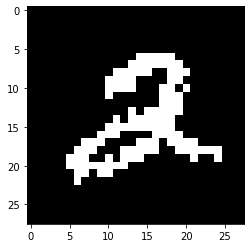

In [ ]:
#importo dati mnist e binarizzo

#Loading MNIST dataset
mnist_data = datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose(
                    [transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))]))

mnist_data.data = (mnist_data.data.type(torch.FloatTensor)/255).bernoulli()
#https://stackoverflow.com/questions/68056122/attributeerror-cant-set-attribute-in-splitting-mnist-dataset

#Lets us visualize a number from the data set
idx = 5
img = mnist_data.train_data[idx]
print("The number shown is the number: {}".format(mnist_data.train_labels[idx]) )
plt.imshow(img , cmap = 'gray')
plt.show()

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


RBM fitting: 1200it [00:05, 239.95it/s]
Epoch:1 ,avg_cost = 3.604112148284912 ,std_cost = 0.6293548941612244 ,avg_grad = 7518.52197265625 ,std_grad = 3126.521484375


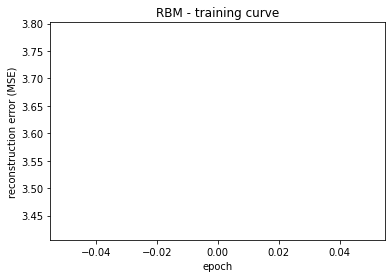

5.143420934677124


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


Epoch: 0, loss: 1.0266374919563532
Epoch: 1, loss: 0.6712473531874518
Epoch: 2, loss: 0.6092528470791876
Epoch: 3, loss: 0.5789674633803467
Epoch: 4, loss: 0.5602673484943808
Epoch: 5, loss: 0.5467480237595737
Epoch: 6, loss: 0.5369744496420026
Epoch: 7, loss: 0.5291247055089722
Epoch: 8, loss: 0.5227439651576181
Epoch: 9, loss: 0.5172879782815775
Epoch: 10, loss: 0.5123065216622005
Epoch: 11, loss: 0.5084115456479291
Epoch: 12, loss: 0.5049627126815418
Epoch: 13, loss: 0.501790644445767
Epoch: 14, loss: 0.4990045721953114
Epoch: 15, loss: 0.49652049170496565
Epoch: 16, loss: 0.4942585344426334
Epoch: 17, loss: 0.4920332770018528
Epoch: 18, loss: 0.4903820903816571
Epoch: 19, loss: 0.48860143680746354
Epoch: 20, loss: 0.4869145177925626
Epoch: 21, loss: 0.48558556134812536
Epoch: 22, loss: 0.4842155669039736
Epoch: 23, loss: 0.4828450484511753
Epoch: 24, loss: 0.4816671387447665
Epoch: 25, loss: 0.48071267443398635
Epoch: 26, loss: 0.47972027443659804
Epoch: 27, loss: 0.478779148093114

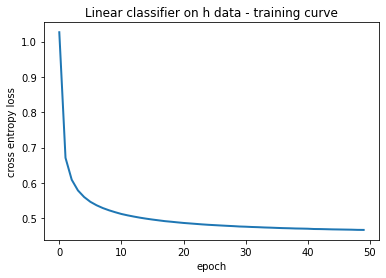

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


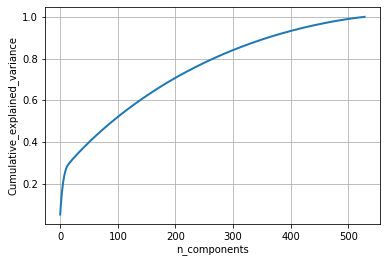

explained variance per component:  [0.05153738 0.0432205 ]
avg euclidean distance, label=0 : 1.313442191117806
avg euclidean distance, label=1 : 1.3809436423579853
avg euclidean distance, label=2 : 1.7401109944625073
avg euclidean distance, label=3 : 1.9133604390207182
avg euclidean distance, label=4 : 1.9510064268857241
avg euclidean distance, label=5 : 1.9683245092442951
avg euclidean distance, label=6 : 1.7953645327494512
avg euclidean distance, label=7 : 2.0822259610375533
avg euclidean distance, label=8 : 1.7725303602569245
avg euclidean distance, label=9 : 2.0872317067913566
mean distance between the cluster center and all other centers, label 0 = 4.553672128253513
mean distance between the cluster center and all other centers, label 1 = 5.142667002148098
mean distance between the cluster center and all other centers, label 2 = 3.005043347676595
mean distance between the cluster center and all other centers, label 3 = 2.5189846091800265
mean distance between the cluster center an

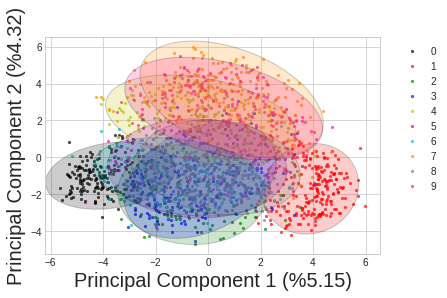

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


RBM fitting: 1200it [00:05, 200.49it/s]
Epoch:1 ,avg_cost = 3.6019210815429688 ,std_cost = 0.6318532824516296 ,avg_grad = 7515.126953125 ,std_grad = 3119.601318359375
RBM fitting: 1200it [00:04, 242.78it/s]
Epoch:2 ,avg_cost = 2.9520576000213623 ,std_cost = 0.17486633360385895 ,avg_grad = 6209.0341796875 ,std_grad = 327.33721923828125
RBM fitting: 1200it [00:04, 244.61it/s]
Epoch:3 ,avg_cost = 2.8120617866516113 ,std_cost = 0.1637343466281891 ,avg_grad = 6012.04833984375 ,std_grad = 315.9825439453125
RBM fitting: 1200it [00:04, 242.07it/s]
Epoch:4 ,avg_cost = 2.7433395385742188 ,std_cost = 0.15764036774635315 ,avg_grad = 5900.95849609375 ,std_grad = 297.802978515625
RBM fitting: 1200it [00:04, 249.14it/s]
Epoch:5 ,avg_cost = 2.699284553527832 ,std_cost = 0.15535816550254822 ,avg_grad = 5838.42724609375 ,std_grad = 295.8829040527344
RBM fitting: 1200it [00:04, 241.05it/s]
Epoch:6 ,avg_cost = 2.661975622177124 ,std_cost = 0.15310300886631012 ,avg_grad = 5787.62451171875 ,std_grad = 292.7

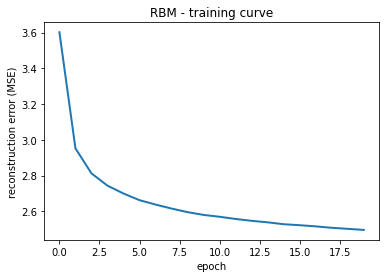

98.73019242286682


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


In [ ]:
start = time.time()

nr_models_to_compare = int(input('how many models do you want to compare?'))

perf_list=[]
models_list =[]
train_epochs_list=[]
Clustering_idx_list=[]
Cluster_radius_list = []
Cluster_distance_list =[]


for i in range(nr_models_to_compare):

  model = model_load_or_create()
  models_list.append(model)
  train_epochs_list.append(model.nr_train_epochs_done)
  perf_list.append(model.test_h_Linear_classifier())

  px = pd.DataFrame(model.h_test_dataset.cpu().numpy())
  y = np.array(model.h_test_labels)
  PCA_explainedVariance_plot(px, model)
  Clustering_idx, avg_Cluster_radius, Avg_Cluster_distance = PCA_analysis(px,y)
  Clustering_idx_list.append(Clustering_idx) 
  Cluster_radius_list.append(avg_Cluster_radius)
  Cluster_distance_list.append(Avg_Cluster_distance)



end = time.time()

print(end - start)

print(perf_list[0])


plt.scatter(train_epochs_list,perf_list,s=100)
plt.axis('tight')
plt.grid()
plt.xlabel('RBM nr of training epochs')
plt.ylabel('Classifier performance')
plt.show()

plt.scatter(train_epochs_list,Clustering_idx_list,s=100)
plt.axis('tight')
plt.grid()
plt.xlabel('RBM nr of training epochs')
plt.ylabel('Clustering_idx (Lazar et al., 2021)')
plt.show()

plt.scatter(train_epochs_list,Cluster_radius_list,s=100)
plt.axis('tight')
plt.grid()
plt.xlabel('RBM nr of training epochs')
plt.ylabel('Clustering_radius(Lazar et al., 2021)')
plt.show()
plt.show()

plt.scatter(train_epochs_list,Cluster_distance_list,s=100)
plt.axis('tight')
plt.grid()
plt.xlabel('RBM nr of training epochs')
plt.ylabel('Clustering_distance(Lazar et al., 2021)')
plt.show()


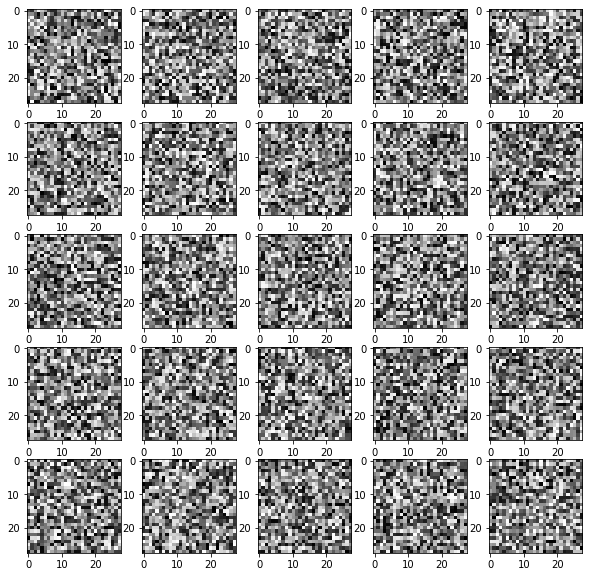

In [ ]:
# visualising layer 1
learned_weights = model.W.cpu().transpose(0,1).numpy()
plt.show()
fig = plt.figure(3, figsize=(10,10))
for i in range(25): 
    sub = fig.add_subplot(5, 5, i+1)
    sub.imshow(learned_weights[i,:].reshape((28,28)), cmap=plt.cm.gray)
plt.show()

<class 'torch.Tensor'>
The original number: 7


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


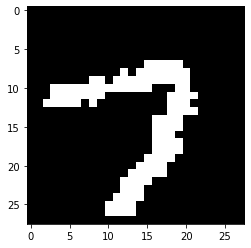

The reconstructed image


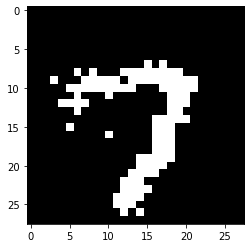

In [ ]:
#recostruction check

idx = random.randint(0,len(mnist_data.train_data))
img = mnist_data.train_data[idx]
lbl = mnist_data.train_labels[idx]
reconstructed_img = img.view(1,-1).type(torch.FloatTensor)

_,reconstructed_img= model.reconstruct(reconstructed_img,1)

print(type(lbl))

reconstructed_img = reconstructed_img.view((28,28)).cpu()
print("The original number: {}".format(lbl))
plt.imshow(img , cmap = 'gray')
plt.show()
print("The reconstructed image")
plt.imshow(reconstructed_img , cmap = 'gray')
plt.show()

label:1


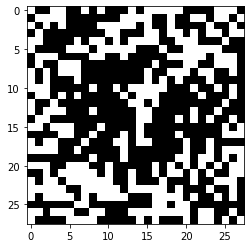

In [ ]:
i=1
h = model.h_from_label(i,10)
print('label:'+str(i))
v, sample_v = model.to_visible(h)
reconstructed_img = sample_v.view((28,28)).cpu()
plt.imshow(reconstructed_img , cmap = 'gray')